In [1]:
from datetime import date
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import SPCI_class as SPCI
from sklearn.model_selection import train_test_split

In [2]:

market_data = yf.download (tickers = "^GSPC", start = "2000-01-01", end = pd.Timestamp.today(), interval = "1d") # start="1927-12-30"
market_data["pct_change"] = market_data["Close"].pct_change()
market_data['date_ordinal'] = pd.to_datetime(market_data.index.to_series()).apply(lambda date: date.toordinal())
market_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,730122
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.038345,730123
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,0.001922,730124
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.000956,730125
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.027090,730126


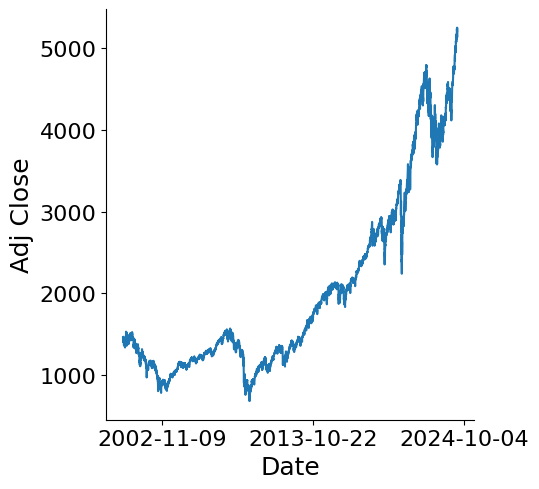

In [5]:
sns.relplot(market_data, x="Date", y="Adj Close", kind="line")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3))

### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.

In [6]:
# Plot prediction intervals on test sample
def plot_ci(model, past_window = 30, alpha=0.1):

    SPCI_class_  = SPCI.SPCI_and_EnbPI(
        torch.from_numpy(x_train), 
        torch.from_numpy(x_test), 
        torch.from_numpy(y_train.reshape(-1)), 
        torch.from_numpy(y_test.reshape(-1)), 
        fit_func=model)
    stride = 1
    SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)

    use_SPCI = True
    smallT = not use_SPCI
    SPCI_class_.compute_PIs_Ensemble_online(alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI, quantile_regr=True, stride=stride)
    results = SPCI_class_.get_results(alpha, 'my_data', 1)

    Pred_ints = SPCI_class_.PIs_Ensemble
    Y_est = SPCI_class_.Ensemble_pred_interval_centers
    Y_predict = SPCI_class_.Y_predict.numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(Y_predict, label=r'$Y$')
    plt.plot(Y_est, label=r'$\hat{Y}$')
    plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$', color='lightblue')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=3)
    plt.xlabel('Test time index')
    plt.ylabel('True $Y$ and prediction')
    actual_cov = 100*results["coverage"].item()
    actual_wid = results["width"].item()
    plt.title(f'Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(market_data["date_ordinal"], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
x_train = x_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6072, 1), (30, 1), (6072, 1), (30, 1))

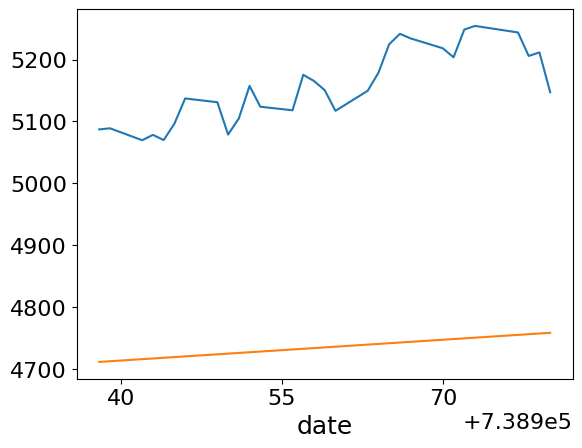

In [8]:
# Fitting polynomial regression model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3)
x_train = poly.fit_transform(x_train)
x_test = poly.transform(x_test)
x_train.shape, x_test.shape

reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)
plt.plot(market_data.iloc[-30:]["date_ordinal"].values.reshape(-1, 1) , y_test)
plt.plot(market_data.iloc[-30:]["date_ordinal"].values.reshape(-1, 1) , y_pred)
plt.gca().set_xlabel('date')
# new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
# plt.gca().set_xticklabels(new_labels)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))

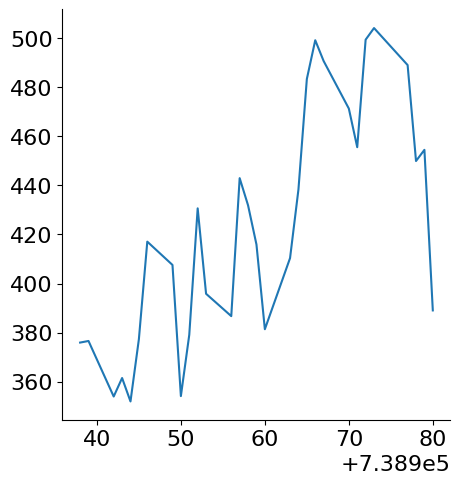

In [9]:
# Plotting residuals
y_pred = reg.predict(x_test)
residuals = y_test - y_pred
sns.relplot(x = market_data.iloc[-30:]["date_ordinal"].values.reshape(-1, 1)[:, 0], y = residuals[:, 0], kind="line")

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.07072901725769043 secs.
Shape of slided residual lists is (30, 6072)
Width at test 0 is 253.06122589111328
Width at test 1 is 469.4612731933594
Width at test 2 is 474.32440185546875
Width at test 3 is 649.1330795288086
Width at test 4 is 458.2440185546875
Width at test 5 is 666.7433013916016
Width at test 6 is 464.9498596191406
Width at test 7 is 471.094970703125
Width at test 8 is 458.0636291503906
Width at test 9 is 660.0341949462891
Width at test 10 is 443.6166687011719
Width at test 11 is 454.00897216796875
Width at test 12 is 460.6715087890625
Width at test 13 is 480.1513977050781
Width at test 14 is 472.7536926269531
Width at test 15 is 447.4689636230469
Width at test 16 is 473.0796203613281
Width at test 17 is 452.2117614746094
Width at test 18 is 469.4458923339844
Width at test 19 is 459.2525634765625
Width at test 20 is 471.1307678222656
Width at test 21 is 457.7283630371094
Width at test 22 is 466.34637451171875
Width

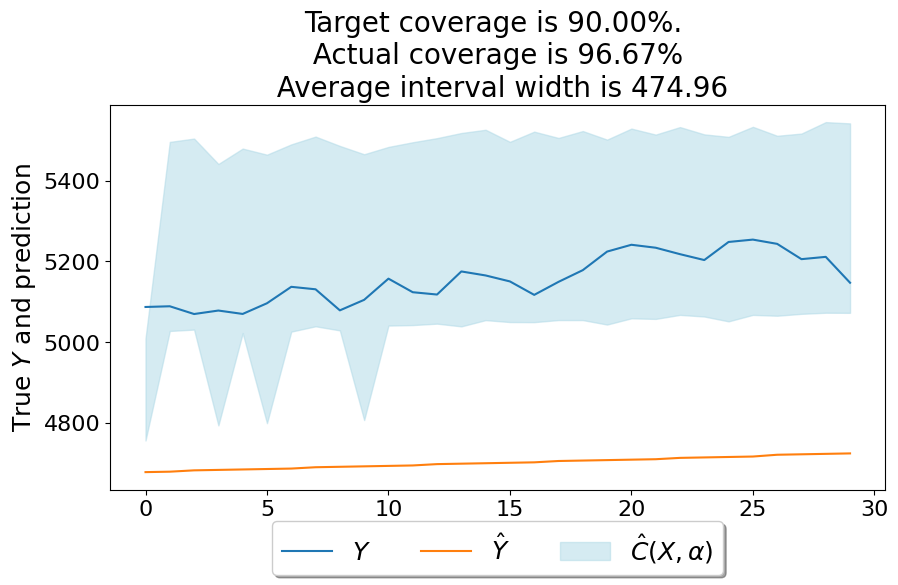

In [10]:
plot_ci(reg)

In [11]:
market_data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,730122
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.038345,730123
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,0.001922,730124
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.000956,730125
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.027090,730126


In [12]:
market_data['5_day_avg'] = market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['30_day_avg']= market_data['Adj Close'].rolling(window=5).mean().shift(1)
market_data['year_avg'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['avg_ratio'] = market_data['5_day_avg']/market_data['year_avg']

market_data['5_day_std'] = market_data['Adj Close'].rolling(window=5).std().shift(1)
market_data['year_std'] = market_data['Adj Close'].rolling(window=365).mean().shift(1)
market_data['std_ratio'] = market_data['5_day_std']/market_data['year_std']
market_data.head(20)

,Open,High,Low,Close,Adj Close,Volume,pct_change,date_ordinal,5_day_avg,30_day_avg,year_avg,avg_ratio,5_day_std,year_std,std_ratio
Date,,,,,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN,730122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.038345,730123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,0.001922,730124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.000956,730125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.027090,730126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,0.011190,730129,1420.333984,1420.333984,NaN,NaN,26.068849,NaN,NaN
2000-01-11,1457.599976,1458.660034,1434.420044,1438.560059,1438.560059,1014000000,-0.013063,730130,1420.809985,1420.809985,NaN,NaN,26.874378,NaN,NaN
2000-01-12,1438.560059,1442.599976,1427.079956,1432.250000,1432.250000,974600000,-0.004386,730131,1428.637988,1428.637988,NaN,NaN,24.698563,NaN,NaN
2000-01-13,1432.250000,1454.199951,1432.250000,1449.680054,1449.680054,1030400000,0.012170,730132,1434.665991,1434.665991,NaN,NaN,19.797119,NaN,NaN


In [13]:
market_data = market_data.dropna()
print(market_data.shape)
x_train, x_test, y_train, y_test = train_test_split(market_data[['5_day_avg', '30_day_avg', 'year_avg', 'avg_ratio', '5_day_std','year_std', 'std_ratio']], market_data["Adj Close"], test_size=30/market_data.shape[0], shuffle=False)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(5737, 15)


((5707, 7), (30, 7), (5707, 1), (30, 1))

In [14]:
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.0820763111114502 secs.
Shape of slided residual lists is (30, 5707)
Width at test 0 is 72.82998085021973
Width at test 1 is 178.32549333572388
Width at test 2 is 159.14268684387207
Width at test 3 is 85.89975929260254
Width at test 4 is 101.6806812286377
Width at test 5 is 74.14774322509766
Width at test 6 is 73.48365783691406
Width at test 7 is 108.1362133026123
Width at test 8 is 88.13984489440918
Width at test 9 is 82.01351928710938
Width at test 10 is 74.95137977600098
Width at test 11 is 106.59793281555176
Width at test 12 is 72.01067352294922
Width at test 13 is 71.0817813873291
Width at test 14 is 95.33798599243164
Width at test 15 is 86.35305595397949
Width at test 16 is 72.21556663513184
Width at test 17 is 94.30126953125
Width at test 18 is 75.7632942199707
Width at test 19 is 75.79715538024902
Width at test 20 is 175.52788019180298
Width at test 21 is 162.12562561035156
Width at test 22 is 140.58495712280273
Width at

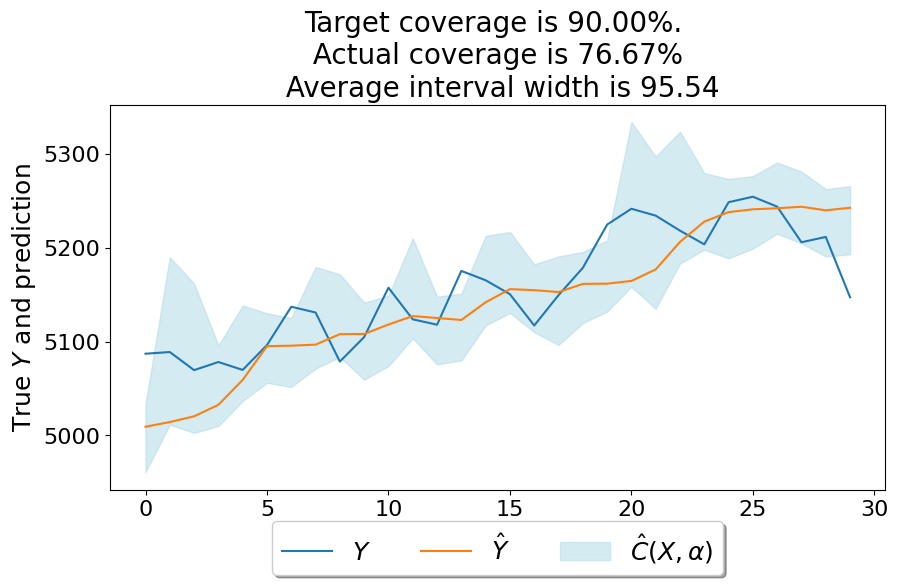

In [15]:
plot_ci(model=model, past_window=1000, alpha=0.1)

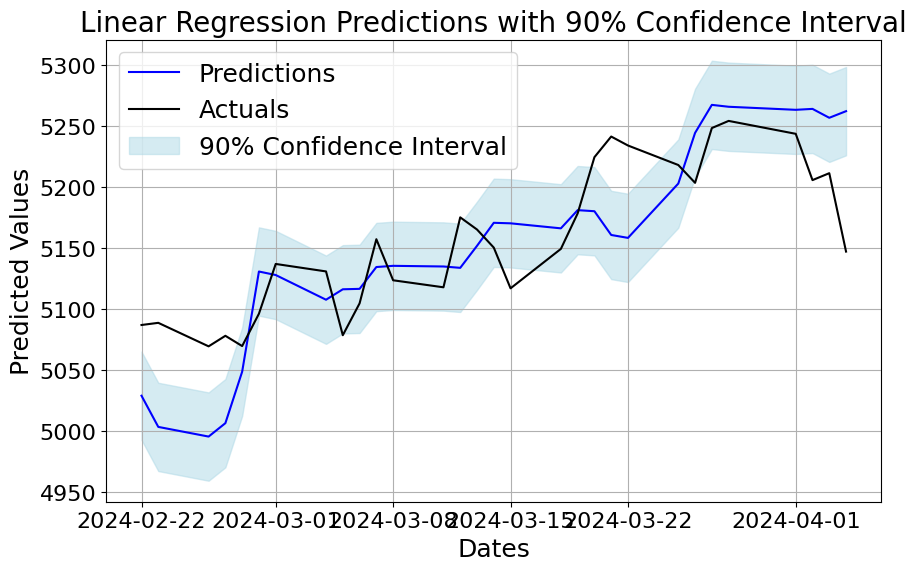

In [17]:
from scipy.stats import t

dates = market_data.iloc[-30:].index.values

predictions = model.predict(x_test)

test_length = 30

alpha = 0.1

residuals = y_test - predictions
mse = np.mean(residuals**2)
se = np.sqrt(mse / (test_length - 8))

t_statistic = t.ppf(1 - alpha / 2, test_length - 8)

lower_bound = predictions - t_statistic * se
upper_bound = predictions + t_statistic * se

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, predictions, color='blue', label='Predictions')
plt.plot(dates, y_test, color='black', label='Actuals')
plt.fill_between(dates, lower_bound, upper_bound, color='lightblue', alpha=0.5, label='90% Confidence Interval')
plt.xlabel('Dates')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Predictions with 90% Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()


In [113]:
x_test.shape

(100, 7)

In [112]:
t_statistic

917.7035086653106